## Background

Here we'll predict the probability of delay of the flights that land or take off from the airport of Santiago de Chile (SCL). This document covers data manipulation, machine learning and visualization of results.

This analysis is fully based in Python's libraries. It used pandas and numpy for data manipulation, matplotlib and seaborn for visualization and sklearn for machine learning.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import sklearn as sk

from utils import *

In [29]:
df = pd.read_csv('dataset_SCL.csv')

/tmp/ipykernel_73420/3467307737.py:1: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset_SCL.csv')


## Exploring the data 🔍

In [30]:
df.head(5)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


In [32]:
df.describe()

,DIA,MES,AÑO
count,68206.000000,68206.000000,68206.000000
mean,15.714790,6.622585,2017.000029
std,8.782886,3.523321,0.005415
min,1.000000,1.000000,2017.000000
25%,8.000000,3.000000,2017.000000
50%,16.000000,7.000000,2017.000000
75%,23.000000,10.000000,2017.000000
max,31.000000,12.000000,2018.000000


### Conclusions

1. More flights departure around the middle of the month and between months of July and August
2. Data is majority **categorical** with DIA, MES and AÑO as **integers**
3. Feature Vlo-O has one **missing value**

## Data management 🗃️

### Cleaning
In order to address the problem and reduce complexity we don't need all features. 
1. As we want to predict the probability if a **scheduled flight** will be delay (> 15 min). Features related to the operation ('-O') can be drop to avoid **data-leakage**.
2. Some features are  **obviously correlate**. For example 'Emp-I' with 'OPERA'. We can keep one of those.
3. We don't really need features related to the city of **origin** as all flight departure from SCL.

In [33]:
df = df.drop(columns=['Vlo-I', 'Ori-I','Vlo-O', 'Ori-O', 'Des-O', 'Emp-O', 'OPERA', 'SIGLAORI', 'SIGLADES'])

### New features

As the data don't include a column about delay.

In [34]:
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'])
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'])

In [35]:
df_synth = pd.DataFrame()
df_synth['high_season'] = np.where(pd.to_datetime(df['Fecha-I']).map(is_high_season),1,0)
df_synth['min_diff'] = (df['Fecha-I'].dt.hour - df['Fecha-O'].dt.hour)*60 + (df['Fecha-I'].dt.minute - df['Fecha-O'].dt.minute)
df_synth['delay_15'] = np.where(df_synth['min_diff'].map(lambda x: x < 0 and np.abs(x) > 15), 1, 0)
df_synth['period_day'] = pd.to_datetime(df['Fecha-I']).map(which_period_day)
df_synth.to_csv('synthetic_features.csv', index=False)

df = pd.concat([df, df_synth], axis=1)

## Delay Ratio

Now we have the data cleaned and new columns with more information. Let's check the importance of some features in the delay ratio:

- By  **destination** (Des-I), **airline** (Emp-I), **day** (DIANOM) of the week and **month** (MES) of the year.
- By **season** (high_season) and **type** of flight (TIPOVUELO) 

$$ \text{delay\_ratio} = \frac{\text{total\_delay\_flights} }{\text{total\_flights}} $$

### By destination

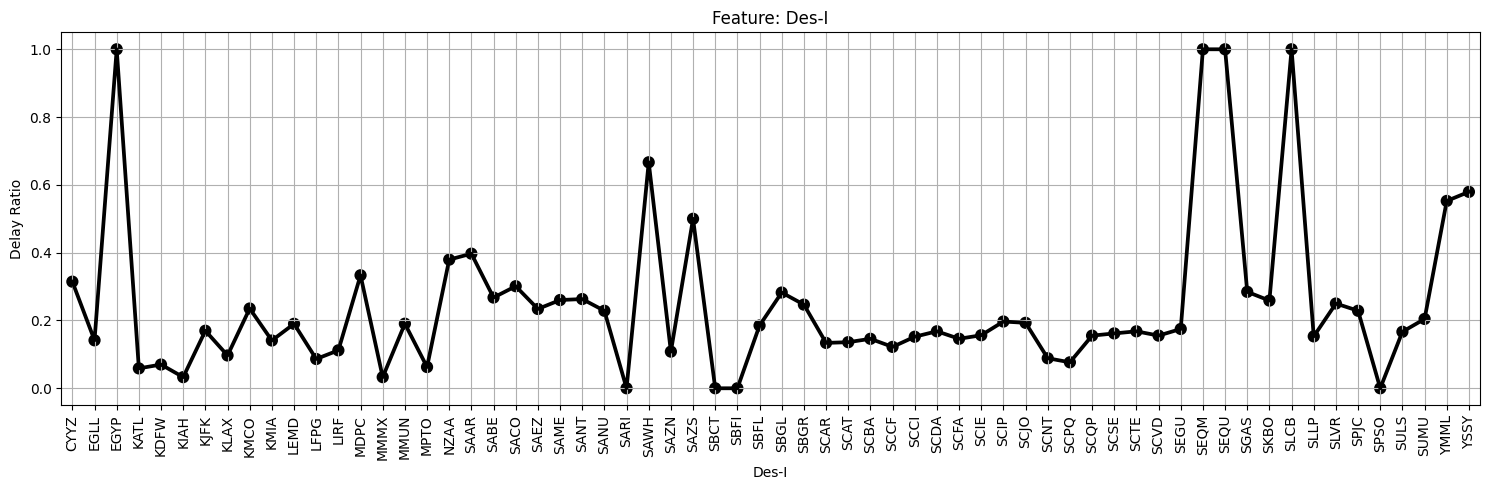

In [36]:
plot_rate_delay(df, ['Des-I'])

### By airline

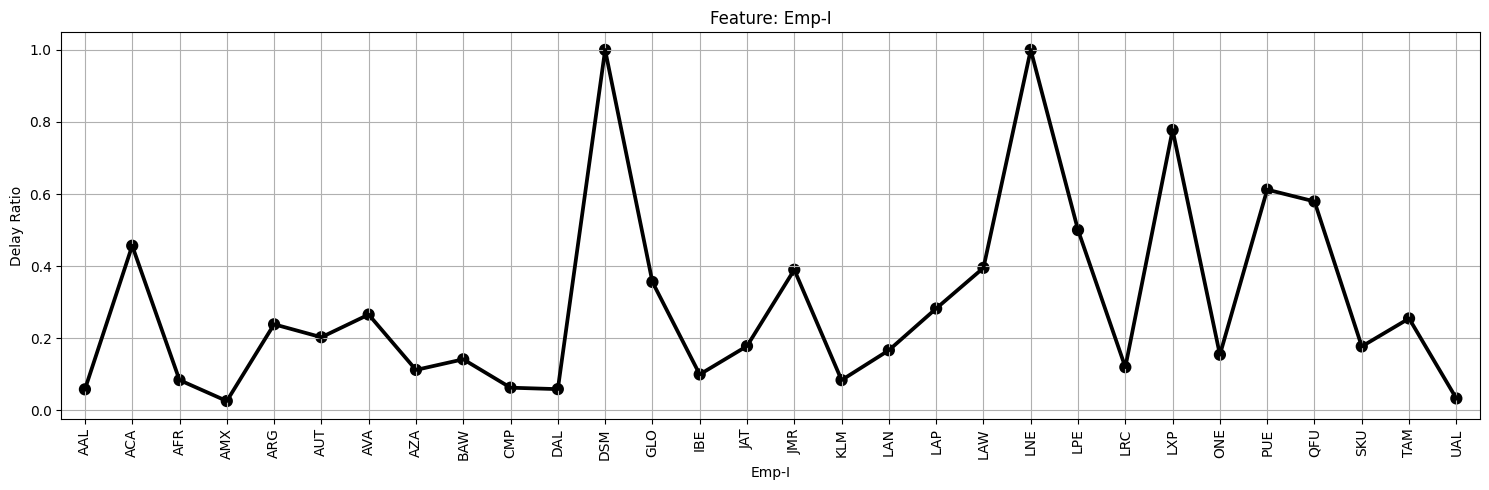

In [37]:
plot_rate_delay(df, ['Emp-I'])

### By day of the week

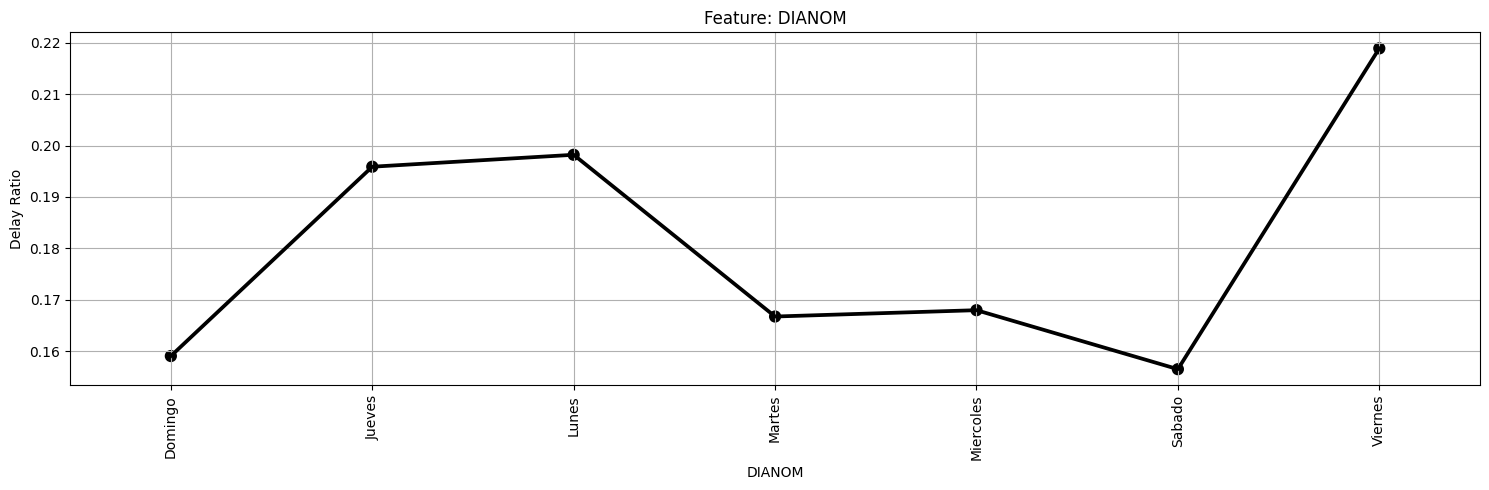

In [38]:
plot_rate_delay(df, ['DIANOM'])

### By month

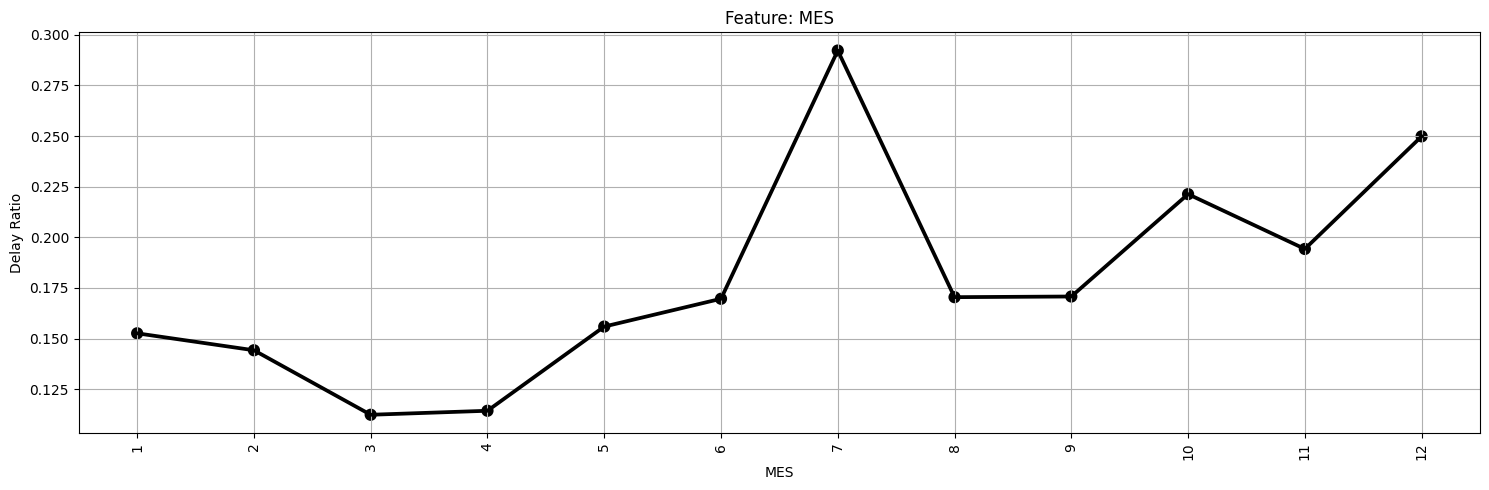

In [39]:
plot_rate_delay(df, ['MES'])

### By season

In [40]:
delay_counts = df[df['delay_15'] == 1].groupby('high_season')['delay_15'].count()
on_time_counts = df[df['delay_15'] == 0].groupby('high_season')['delay_15'].count()
df_counts = pd.DataFrame({'delay': delay_counts, 'on_time': on_time_counts})
df_counts['delay'] = df_counts['delay'].fillna(0)
df_counts['on_time'] = df_counts['on_time'].fillna(0)
df_counts['delay_ratio'] = df_counts['delay'] / (df_counts['delay'] + df_counts['on_time'])
df_counts


,delay,on_time,delay_ratio
high_season,,,
0,9784,47343,0.171268
1,2594,8485,0.234137


### By type of flight

In [41]:
delay_counts = df[df['delay_15'] == 1].groupby('TIPOVUELO')['delay_15'].count()
on_time_counts = df[df['delay_15'] == 0].groupby('TIPOVUELO')['delay_15'].count()
df_counts = pd.DataFrame({'delay': delay_counts, 'on_time': on_time_counts})
df_counts['delay'] = df_counts['delay'].fillna(0)
df_counts['on_time'] = df_counts['on_time'].fillna(0)
df_counts['delay_ratio'] = df_counts['delay'] / (df_counts['delay'] + df_counts['on_time'])
df_counts

,delay,on_time,delay_ratio
TIPOVUELO,,,
I,6835,24405,0.218790
N,5543,31423,0.149949


## Machine learning (Part I) 🤖

Before go through an algorithm method. Why we need to predict the delay flight's probabilities?


In [42]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Check for inbalance data

In [43]:
print(f"Number of delay flights (1): {df['delay_15'].value_counts()[1]}")
print(f"Number of on_time flights (0): {df['delay_15'].value_counts()[0]}")

Number of delay flights (1): 12378
Number of on_time flights (0): 55828


Data is inbalance. Means that 82% of the flights are on_time (0). This could be an issue.

### Split dataset into train and test

In [44]:
predictors = ['Des-I','Emp-I','DIANOM','TIPOVUELO','high_season','period_day']
target = ['delay_15']

X = df[predictors]
y = df[target]


In [45]:
X_encoded = pd.get_dummies(X, columns=['Des-I', 'Emp-I', 'DIANOM', 'TIPOVUELO', 'period_day'])
features_encoded = X_encoded.columns

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.25, random_state=42)

### Scaling the data

In [47]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

### 1. Logistic Regression Model

Because of the target, the predicted value is between 0 and 1. A logistic regression model could be a good start.

In [55]:
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train, y_train.values.ravel())
y_pred = logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8186722965048088

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.99      0.90     13926
           1       0.58      0.04      0.07      3126

    accuracy                           0.82     17052
   macro avg       0.70      0.52      0.48     17052
weighted avg       0.78      0.82      0.75     17052


Confusion Matrix:
[[13843    83]
 [ 3009   117]]


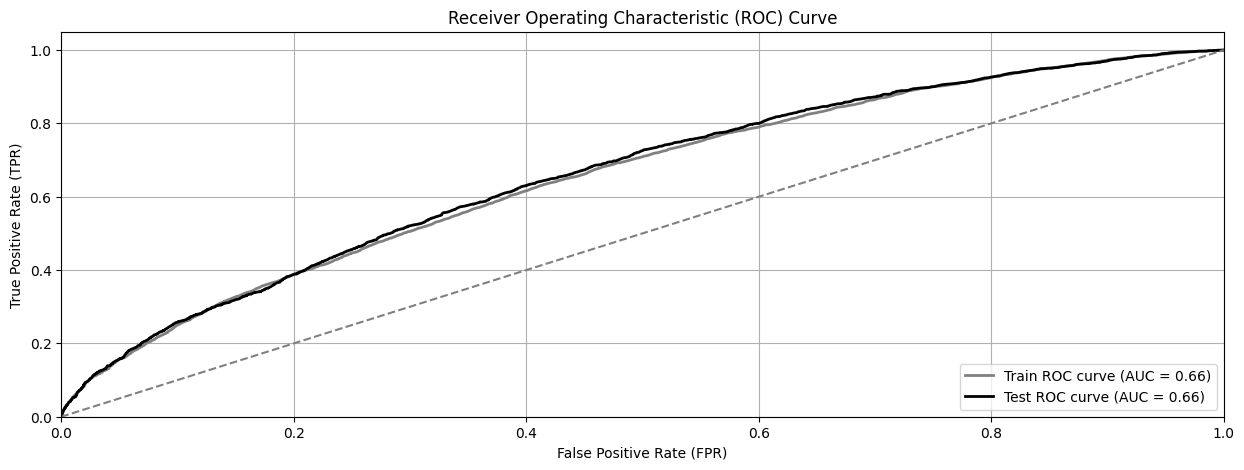

In [56]:
y_prob_train = logistic_model.predict_proba(X_train)
y_prob_test = logistic_model.predict_proba(X_test)
plot_roc_curve(y_prob_test[:,1],y_prob_train[:,1], y_test, y_train)

### 2. Decision Tree Classifier 

Because of the ratio_delay plots, some feature seems to have more importance in the delay prediction.
1. A flight scheduled for friday has more chances than one sheduled for other day of the week.
2. Airline LPX has a delay ratio of 80%.
3. Flights with destination to SAWH has around 60% ratio of delay.

For that, a decision tree classifier might be a good approach.

In [79]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train.values.ravel())
y_pred = dt_clf.predict(X_test)

print(f"Accuracy: {accuracy}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.8185550082101807

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     13926
           1       0.50      0.07      0.13      3126

    accuracy                           0.82     17052
   macro avg       0.66      0.53      0.51     17052
weighted avg       0.76      0.82      0.76     17052


Confusion Matrix:
[[13692   234]
 [ 2896   230]]


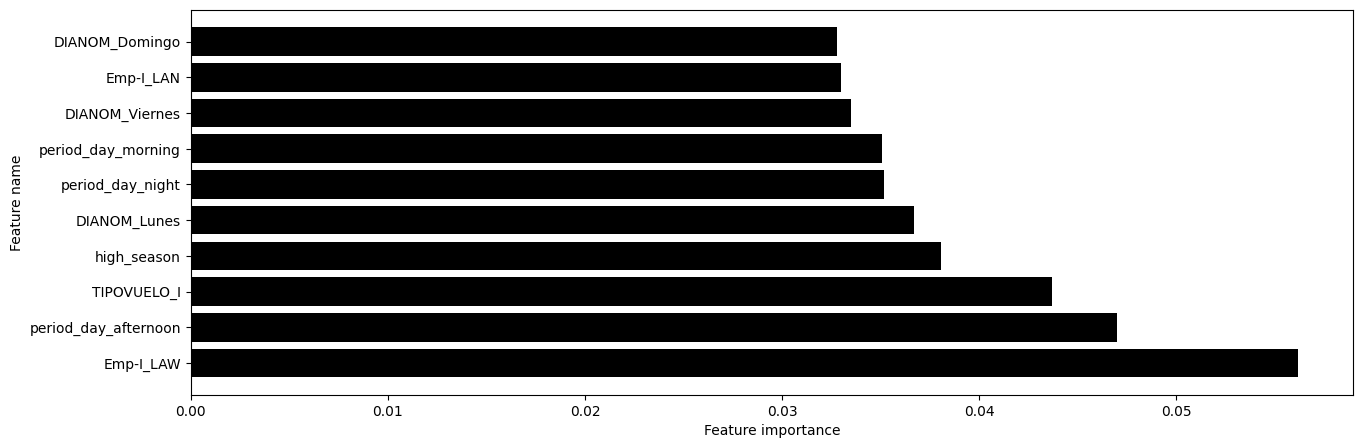

In [80]:
plot_feature_importances_top10(dt_clf, features_encoded)

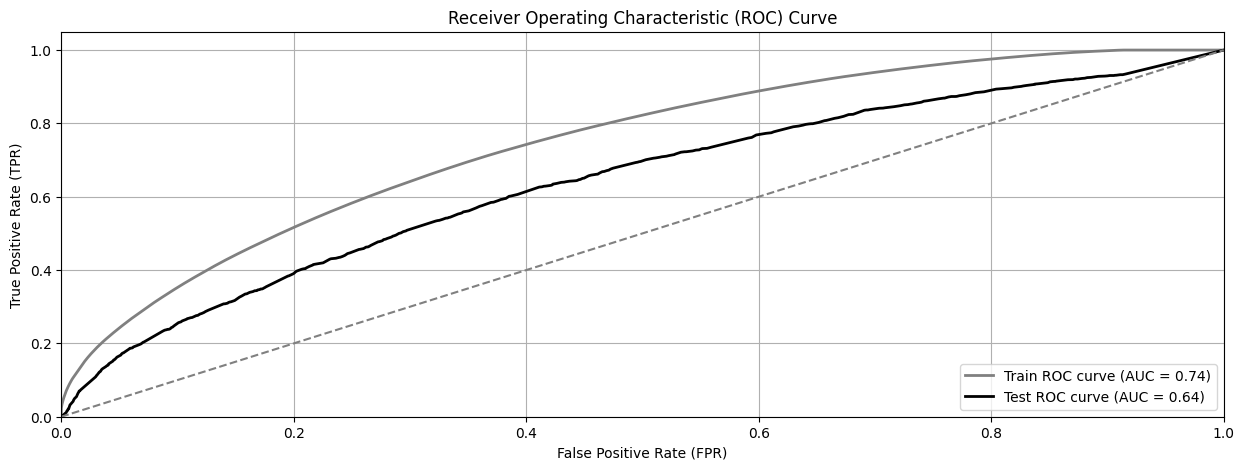

In [81]:
y_prob_train = dt_clf.predict_proba(X_train)
y_prob_test = dt_clf.predict_proba(X_test)
plot_roc_curve(y_prob_test[:,1],y_prob_train[:,1], y_test, y_train)

### 3. Random Forest Classifier

Both last model are poorly when predict delay flights (1). 

With a max recall of 0.07. This is because the unbalance data.

Accuracy: 0.8156228008444757

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     13926
           1       0.48      0.09      0.15      3126

    accuracy                           0.82     17052
   macro avg       0.66      0.53      0.53     17052
weighted avg       0.76      0.82      0.76     17052


Confusion Matrix:
[[13622   304]
 [ 2840   286]]


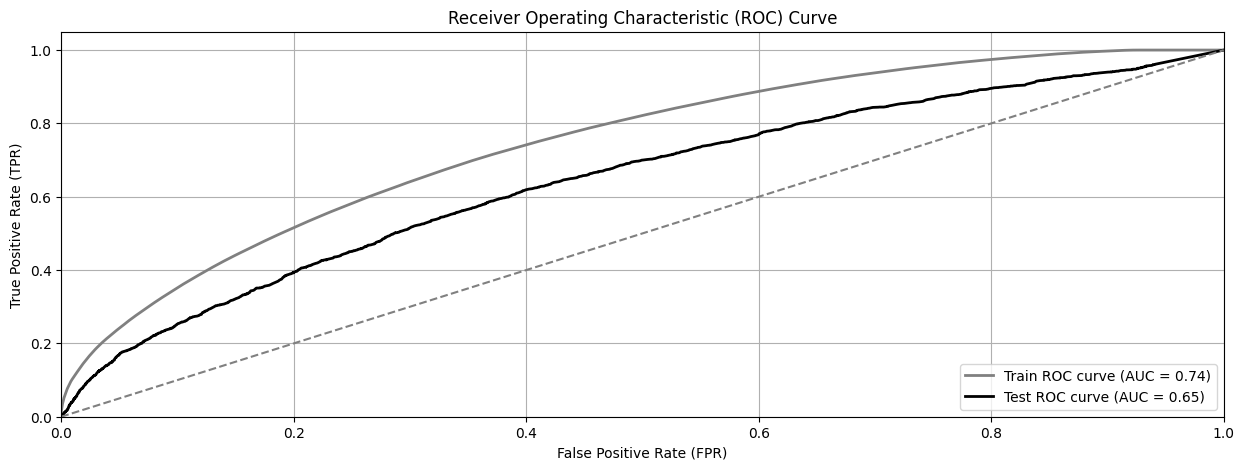

In [85]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_clf.fit(X_train, y_train.values.ravel())
y_pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

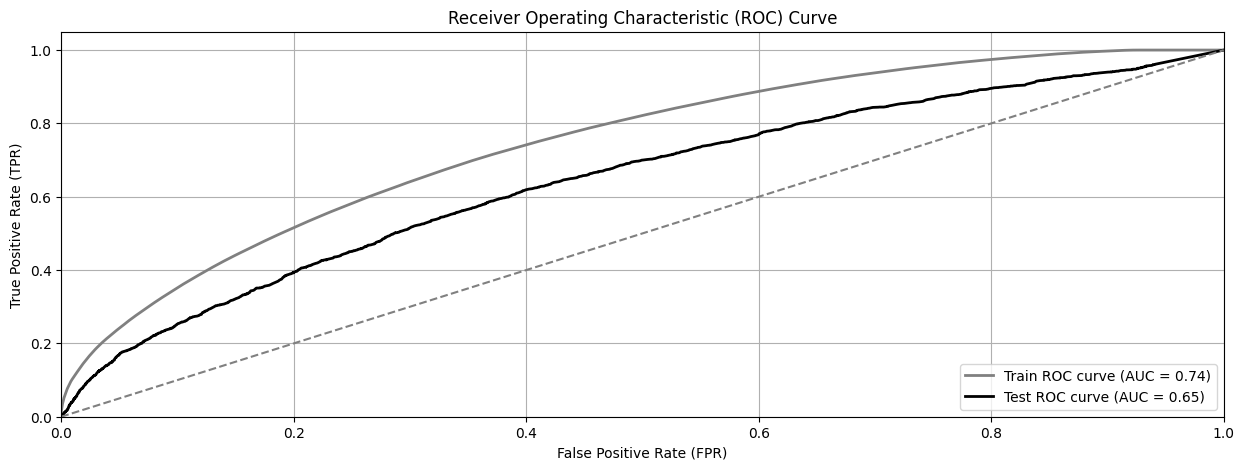

In [86]:
y_prob_train = rf_clf.predict_proba(X_train)
y_prob_test = rf_clf.predict_proba(X_test)
plot_roc_curve(y_prob_test[:,1], y_prob_train[:,1], y_test, y_train)

## Machine learning (Part II) 🤖

Gradient Boosted Decision Tree (Acc : 0.82 and AUC : 0.66) got the best results on test samples.

In [87]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0]
}